In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("cleaned_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                761 non-null    int64  
 1   campaign_id          761 non-null    int64  
 2   age                  761 non-null    object 
 3   gender               761 non-null    object 
 4   interest1            761 non-null    int64  
 5   interest2            761 non-null    int64  
 6   interest3            761 non-null    int64  
 7   impressions          761 non-null    float64
 8   clicks               761 non-null    int64  
 9   spent                761 non-null    float64
 10  total_conversion     761 non-null    float64
 11  approved_conversion  761 non-null    float64
dtypes: float64(4), int64(6), object(2)
memory usage: 71.5+ KB


In [4]:
df.head(2)

,ad_id,campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,916,30-34,M,15,17,17,7350.0,1,1.43,2.0,1.0
1,708749,916,30-34,M,16,19,21,17861.0,2,1.82,2.0,0.0


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
import joblib

In [22]:
def explore_data(df):
    print("Dataset Shape:", df.shape)
    print("\nData Types:")
    print(df.dtypes)
    
    print("\nBasic Statistics:")
    print(df.describe())
    
    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Correlation matrix
    plt.figure(figsize=(12, 10))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()
    
    # Distribution of target variable (let's assume we're predicting approved_conversion)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['approved_conversion'], kde=True)
    plt.title('Distribution of Approved Conversions')
    plt.show()
    
    # Relationship between features and target
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    numeric_cols = ['impressions', 'clicks', 'spent', 'interest1', 'interest2', 'interest3']
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            sns.scatterplot(x=col, y='approved_conversion', data=df, ax=axes[i])
            axes[i].set_title(f'{col} vs Approved Conversion')
    
    plt.tight_layout()
    plt.show()
    
    # Categorical features analysis
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='age', y='approved_conversion', data=df)
    plt.title('Approved Conversions by Age Group')
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='gender', y='approved_conversion', data=df)
    plt.title('Approved Conversions by Gender')
    plt.show()


In [23]:
def preprocess_and_train(df, target='approved_conversion'):
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # Define features and target
    X = data.drop(columns=[target, 'ad_id'])  # Removing ad_id as it's just an identifier
    y = data[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Identify categorical and numerical columns
    categorical_cols = ['age', 'gender']
    numeric_cols = ['campaign_id', 'interest1', 'interest2', 'interest3', 
                   'impressions', 'clicks', 'spent', 'total_conversion']
    
    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Define models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    # Parameter grids for GridSearchCV
    param_grids = {
        'Linear Regression': {},
        'Ridge Regression': {'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
        'Lasso Regression': {'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
        'Random Forest': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'regressor__n_estimators': [50, 100, 200],
            'regressor__learning_rate': [0.01, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7],
            'regressor__subsample': [0.8, 1.0]
        }
    }
    
    # Store results
    results = {}
    best_models = {}
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Create a pipeline with preprocessing and the regressor
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(f_regression, k='all')),  # Feature selection to combat overfitting
            ('regressor', model)
        ])
        
        # GridSearchCV
        grid_search = GridSearchCV(
            pipeline,
            param_grids[model_name],
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Make predictions
        y_pred = best_model.predict(X_test)
        
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        results[model_name] = {
            'Best Parameters': grid_search.best_params_,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'MAE': mae
        }
        
        print(f"{model_name} Results:")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        # Feature importance (for tree-based models)
        if model_name in ['Random Forest', 'Gradient Boosting']:
            feature_names = (
                numeric_cols +
                list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
                    .get_feature_names_out(categorical_cols))
            )
            feature_importance = best_model.named_steps['regressor'].feature_importances_
            
            # Only keep the top k features selected by SelectKBest
            if hasattr(best_model.named_steps['feature_selection'], 'get_support'):
                support = best_model.named_steps['feature_selection'].get_support()
                feature_names = np.array(feature_names)[support]
                feature_importance = feature_importance[support]
            
            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sorted_idx = np.argsort(feature_importance)
            plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
            plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
            plt.title(f'Feature Importance ({model_name})')
            plt.tight_layout()
            plt.show()
    
    # Find the best model overall
    best_model_name = min(results, key=lambda x: results[x]['RMSE'])
    print(f"\nBest Model: {best_model_name}")
    print(f"RMSE: {results[best_model_name]['RMSE']:.4f}")
    print(f"R2: {results[best_model_name]['R2']:.4f}")
    
    return results, best_models[best_model_name], best_models


In [24]:
def make_predictions(model, new_data):
    return model.predict(new_data)

In [25]:
def check_overfitting(model, X, y, cv=5):
    # Get feature names
    feature_names = (
        model.named_steps['preprocessor'].transformers_[0][2] +  # Numeric columns
        list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
             .get_feature_names_out(model.named_steps['preprocessor'].transformers_[1][2]))  # Categorical columns
    )
    
    # Create a new dataframe with transformed features
    X_transformed = model.named_steps['preprocessor'].transform(X)
    
    # Get feature selection mask if applicable
    if hasattr(model.named_steps['feature_selection'], 'get_support'):
        support = model.named_steps['feature_selection'].get_support()
        X_transformed = model.named_steps['feature_selection'].transform(X_transformed)
        feature_names = np.array(feature_names)[support]
    
    # Cross-validation scores
    cv_scores = cross_val_score(model.named_steps['regressor'], X_transformed, y, 
                              cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    print("Cross-Validation RMSE Scores:", rmse_scores)
    print("Mean RMSE:", np.mean(rmse_scores))
    print("Standard Deviation of RMSE:", np.std(rmse_scores))
    
    # If standard deviation is high relative to the mean, it might indicate overfitting
    if np.std(rmse_scores) > 0.2 * np.mean(rmse_scores):
        print("Warning: High variance in cross-validation scores, might indicate overfitting.")
    else:
        print("Model seems to generalize well across folds.")


In [26]:
from sklearn.model_selection import cross_val_score


In [27]:
def check_overfitting(model, X, y, cv=5):
    # Get feature names
    feature_names = (
        model.named_steps['preprocessor'].transformers_[0][2] +  # Numeric columns
        list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
             .get_feature_names_out(model.named_steps['preprocessor'].transformers_[1][2]))  # Categorical columns
    )
    
    # Create a new dataframe with transformed features
    X_transformed = model.named_steps['preprocessor'].transform(X)
    
    # Get feature selection mask if applicable
    if hasattr(model.named_steps['feature_selection'], 'get_support'):
        support = model.named_steps['feature_selection'].get_support()
        X_transformed = model.named_steps['feature_selection'].transform(X_transformed)
        feature_names = np.array(feature_names)[support]
    
    # Cross-validation scores
    cv_scores = cross_val_score(model.named_steps['regressor'], X_transformed, y, 
                              cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    print("Cross-Validation RMSE Scores:", rmse_scores)
    print("Mean RMSE:", np.mean(rmse_scores))
    print("Standard Deviation of RMSE:", np.std(rmse_scores))
    
    # If standard deviation is high relative to the mean, it might indicate overfitting
    if np.std(rmse_scores) > 0.2 * np.mean(rmse_scores):
        print("Warning: High variance in cross-validation scores, might indicate overfitting.")
    else:
        print("Model seems to generalize well across folds.")


In [28]:
def suggest_overfitting_solutions(results):
    best_model_name = min(results, key=lambda x: results[x]['RMSE'])
    best_r2 = results[best_model_name]['R2']
    
    print("\nOverfitting Prevention Recommendations:")
    
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        print("1. Reduce model complexity:")
        print("   - Decrease max_depth")
        print("   - Increase min_samples_split and min_samples_leaf")
        print("   - Use fewer estimators (n_estimators)")
        
    if best_model_name in ['Ridge Regression', 'Lasso Regression']:
        print("1. Adjust regularization strength:")
        print("   - Experiment with different alpha values")
    
    print("2. Feature selection:")
    print("   - Use SelectKBest with different k values")
    print("   - Try SelectFromModel to automatically select features")
    
    print("3. More data collection if possible")
    
    print("4. Additional techniques:")
    print("   - Try polynomial features with regularization")
    print("   - Ensemble multiple models")
    print("   - Use k-fold cross-validation with different k values")


In [29]:
def suggest_overfitting_solutions(results):
    best_model_name = min(results, key=lambda x: results[x]['RMSE'])
    best_r2 = results[best_model_name]['R2']
    
    print("\nOverfitting Prevention Recommendations:")
    
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        print("1. Reduce model complexity:")
        print("   - Decrease max_depth")
        print("   - Increase min_samples_split and min_samples_leaf")
        print("   - Use fewer estimators (n_estimators)")
        
    if best_model_name in ['Ridge Regression', 'Lasso Regression']:
        print("1. Adjust regularization strength:")
        print("   - Experiment with different alpha values")
    
    print("2. Feature selection:")
    print("   - Use SelectKBest with different k values")
    print("   - Try SelectFromModel to automatically select features")
    
    print("3. More data collection if possible")
    
    print("4. Additional techniques:")
    print("   - Try polynomial features with regularization")
    print("   - Ensemble multiple models")
    print("   - Use k-fold cross-validation with different k values")


In [30]:
def export_model(model, filename='best_model.joblib'):
    """Export the trained model to a file using joblib."""
    joblib.dump(model, filename)
    print(f"Model successfully exported to {filename}")
    return filename

Starting ML pipeline for ad conversion prediction...

--- Exploratory Data Analysis ---
Dataset Shape: (761, 12)

Data Types:
ad_id                    int64
campaign_id              int64
age                     object
gender                  object
interest1                int64
interest2                int64
interest3                int64
impressions            float64
clicks                   int64
spent                  float64
total_conversion       float64
approved_conversion    float64
dtype: object

Basic Statistics:
              ad_id  campaign_id   interest1   interest2   interest3  \
count  7.610000e+02   761.000000  761.000000  761.000000  761.000000   
mean   8.956389e+05  1011.855453   25.473062   28.977661   28.984231   
std    1.670937e+05   113.981878   15.508898   15.607548   15.604816   
min    7.087460e+05   916.000000    2.000000    3.000000    3.000000   
25%    7.480860e+05   936.000000   16.000000   19.000000   19.000000   
50%    7.811750e+05   936.000000   22

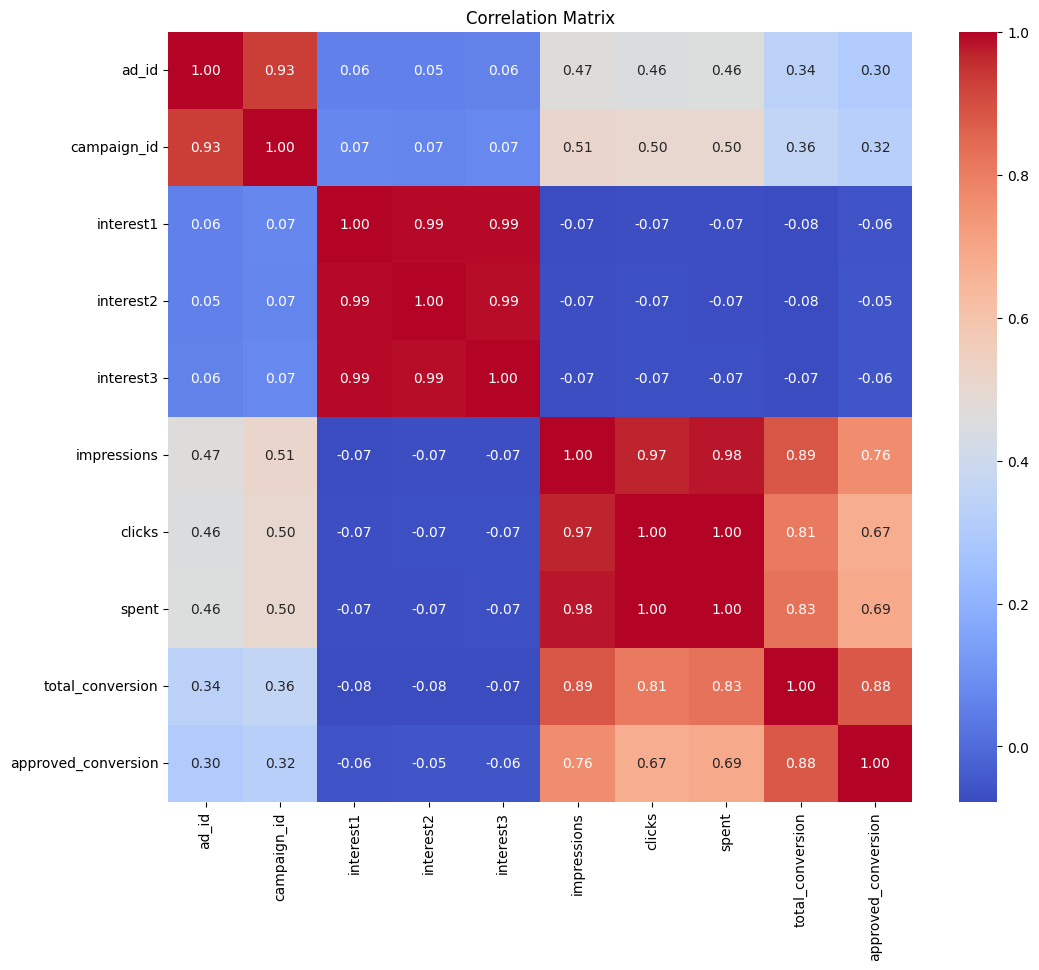

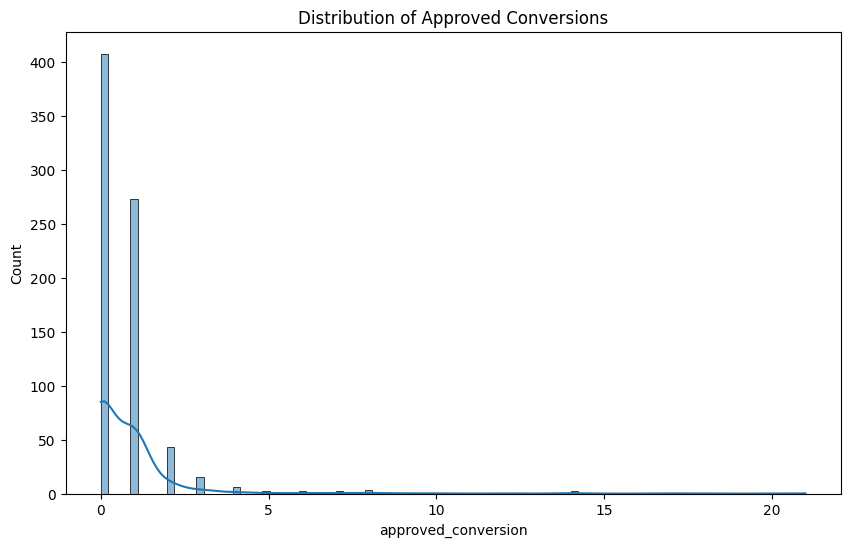

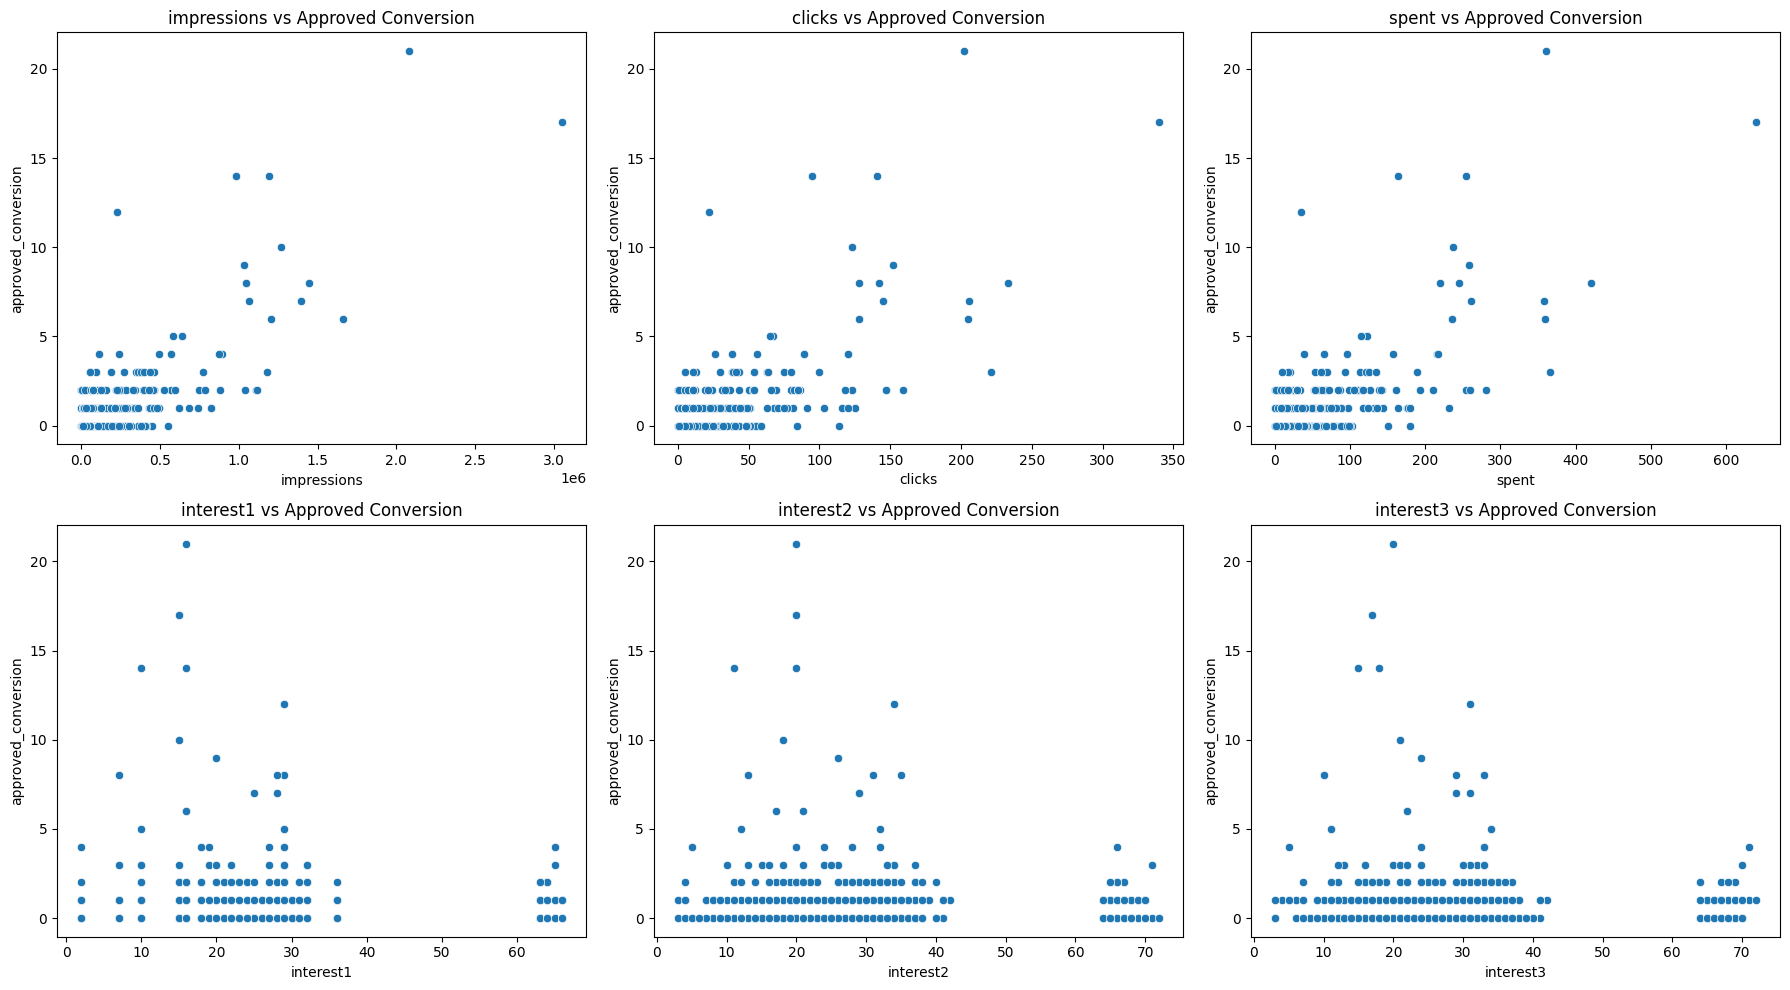

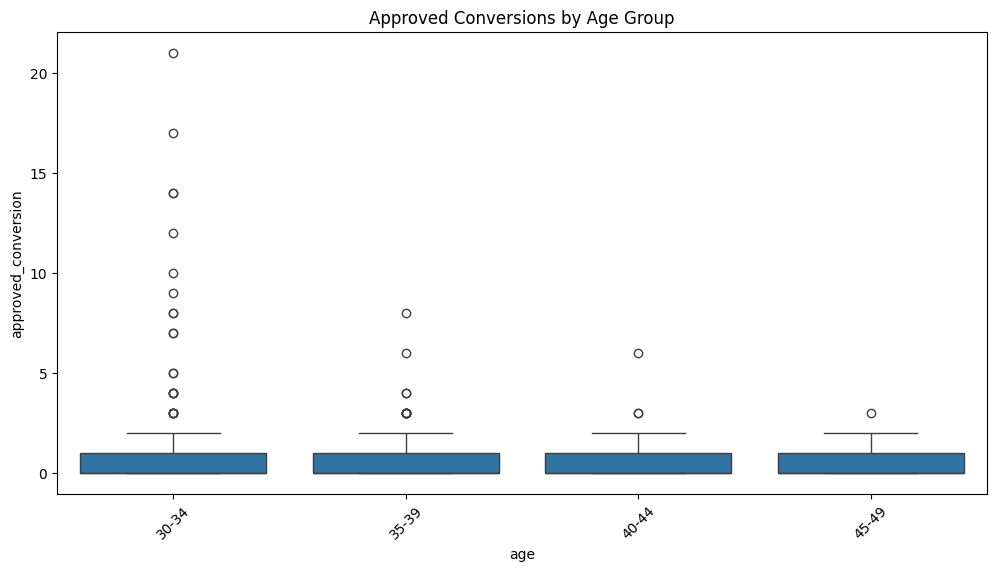

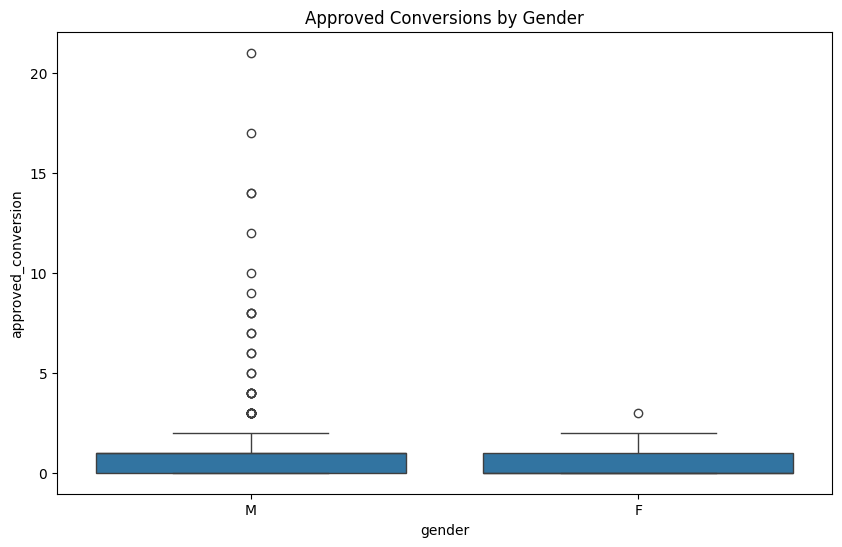


--- Model Training and Evaluation ---

Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Linear Regression Results:
Best Parameters: {}
MSE: 0.6439
RMSE: 0.8025
R2: 0.6573
MAE: 0.6072

Training Ridge Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Ridge Regression Results:
Best Parameters: {'regressor__alpha': 10.0}
MSE: 0.6516
RMSE: 0.8072
R2: 0.6533
MAE: 0.6031

Training Lasso Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Lasso Regression Results:
Best Parameters: {'regressor__alpha': 0.1}
MSE: 0.6495
RMSE: 0.8059
R2: 0.6544
MAE: 0.5989

Training Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest Results:
Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 50}
MSE: 0.6519
RMSE: 0.8074
R2: 0.6531
MAE: 0.5956


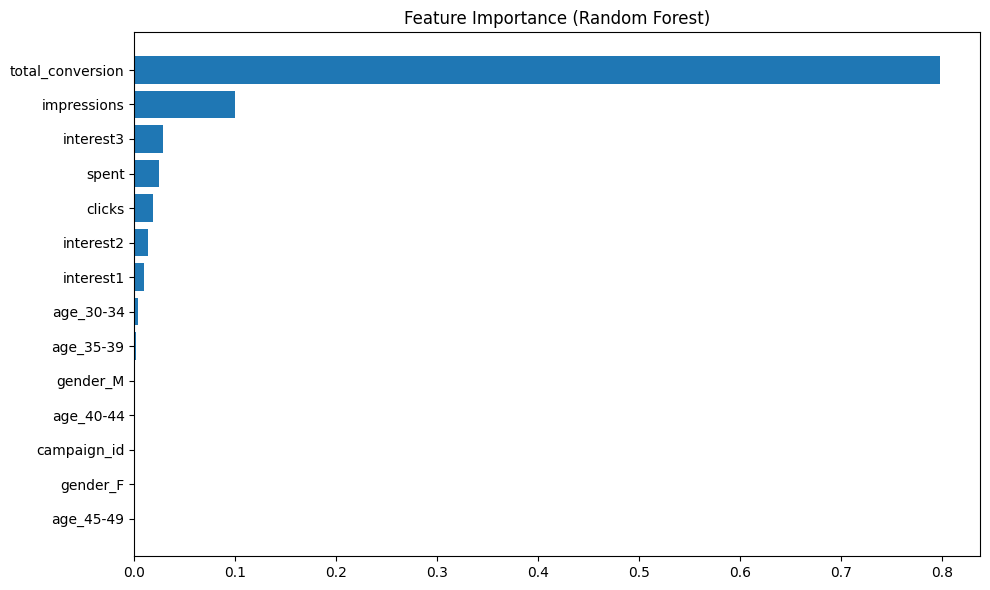


Training Gradient Boosting...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Gradient Boosting Results:
Best Parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 3, 'regressor__n_estimators': 50, 'regressor__subsample': 1.0}
MSE: 0.8492
RMSE: 0.9215
R2: 0.5481
MAE: 0.6065


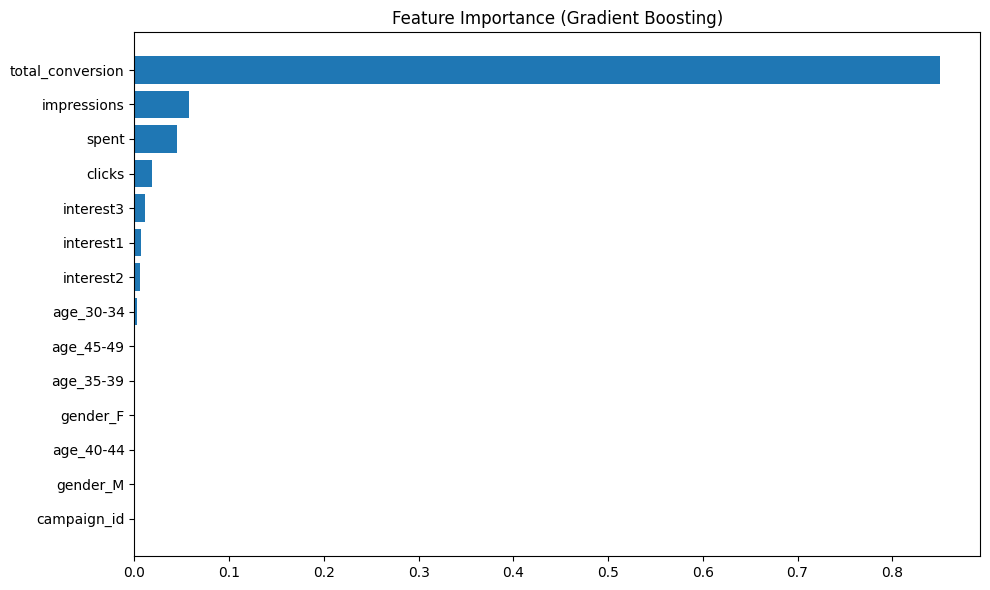


Best Model: Linear Regression
RMSE: 0.8025
R2: 0.6573

--- Overfitting Analysis ---
Cross-Validation RMSE Scores: [0.5373802  0.52235718 0.50310337 1.30440702 1.31351533]
Mean RMSE: 0.836152619369756
Standard Deviation of RMSE: 0.38621022054947046

Overfitting Prevention Recommendations:
2. Feature selection:
   - Use SelectKBest with different k values
   - Try SelectFromModel to automatically select features
3. More data collection if possible
4. Additional techniques:
   - Try polynomial features with regularization
   - Ensemble multiple models
   - Use k-fold cross-validation with different k values
Model successfully exported to ad_conversion_best_model.joblib

Best model exported to ad_conversion_best_model.joblib

ML pipeline execution completed.

Exporting all trained models...
Model successfully exported to ad_conversion_linear_regression_model.joblib
Model successfully exported to ad_conversion_ridge_regression_model.joblib
Model successfully exported to ad_conversion_lasso

In [31]:
print("Starting ML pipeline for ad conversion prediction...")

# Step 1: Exploratory Data Analysis
print("\n--- Exploratory Data Analysis ---")
explore_data(df)

# Step 2 & 3: Preprocessing and Model Training with GridSearchCV
print("\n--- Model Training and Evaluation ---")
X = df.drop(columns=['approved_conversion', 'ad_id'])  # Features
y = df['approved_conversion']  # Target
results, best_model, all_models = preprocess_and_train(df)

# Step 4: Check for overfitting
print("\n--- Overfitting Analysis ---")
check_overfitting(best_model, X, y)

# Step 5: Suggestions to combat overfitting
suggest_overfitting_solutions(results)

# Step 6: Export the best model
model_file = export_model(best_model, 'ad_conversion_best_model.joblib')
print(f"\nBest model exported to {model_file}")

print("\nML pipeline execution completed.")

# If you want to export all models
print("\nExporting all trained models...")
for model_name, model in all_models.items():
    filename = f"ad_conversion_{model_name.lower().replace(' ', '_')}_model.joblib"
    export_model(model, filename)